In [1]:
import tensorflow as tf
import numpy as np
import wfdb
import pywt
import os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
sig_len = 1280

#### Helper functions

In [3]:
# Function to read the data from a given path to the .hea file
def read_data(path,type):
    signals, fields = wfdb.rdsamp(path,sampfrom=0)
    if(type=="normal"):
        data_array = signals.T[1]
    if(type=="cad"):
        data_array = signals.T[0]

    # Returns a data array of length that is a multiple of sig_len
    return data_array[:sig_len*int(data_array.shape[0]/sig_len)]

# Does wavelet transform to denoise the entire data array
def wavelet_transform(data_array):
    coefficient = pywt.wavedec(data_array,wavelet='db6',level=5)
    coefficient[0] = np.zeros_like(coefficient[0])
    transformed_signal = pywt.waverec(coefficient,wavelet='db6')

    data_array = transformed_signal

# Reshapes data array such that each row becomes signal segment of length sig_len
def reshape_data(data_array):
    return data_array.reshape(int(data_array.shape[0]/sig_len),sig_len)

# Does the preprocessing on the data segment of length sig_len
def augment_signal(data_array):
    # Normalization
    data_array = np.array((data_array-np.mean(data_array))/np.std(data_array))

    # Generate random sinusoidal noise signal
    starting_phase = np.random.uniform(-180, -90)
    # ending_phase = np.random.uniform(90, 180)      # I am not using this ending phase part here
    amplitude = np.random.uniform(-2, 2)
    time = np.arange(data_array.shape[0])  
    sinusoidal_noise_signal = amplitude * np.sin(2 * np.pi * time + np.radians(starting_phase))

    # Generate random Gaussian noise signal
    gaussian_noise_signal = np.random.normal(0, 0.05, len(data_array))

    data_array = data_array + sinusoidal_noise_signal + gaussian_noise_signal

# Converts the linear signal of shape (1280,) to an image of shape(211,24)
def make_img(data_array):
    result = []
    idx=0
    for i in range(0,24):
        result.append(data_array[idx:idx+211])
        idx+=40

    return np.array(result).T

#### Reading the data

In [4]:
# Path to the data files
# Path to CAD ECG data
path1 = r"C:\Users\123na\Downloads\Heart Disease prediction\Data\CAD"
# Path to normal ECG data
path2 = r"C:\Users\123na\Downloads\Heart Disease prediction\Data\fantasia-database-1.0.0" 

list1 = os.listdir(path1)    # File list in directory at path1
list2 = os.listdir(path2)    # File list in directory at path2

list1 = [x for x in list1 if x[-4:]==".hea"]         # files in list1 ending with ".hea"
list1 = [x[:3] for x in list1]                       # removes ".hea" from files names in list1
path_cad = [os.path.join(path1,x) for x in list1]    # joins path1 with filenames in list1

list2 = [x for x in list2 if x[-4:]==".hea"]         # files in list2 ending with ".hea"
list2 = [x[:5] for x in list2]                       # removes ".hea" from files names in list2
path_normal = [os.path.join(path2,x) for x in list2] # joins path2 with filenames in list2

'''  There are 39 normal candidates and 9 CAD diagnosed candidate in our data   '''

'  There are 39 normal candidates and 9 CAD diagnosed candidate in our data   '

In [5]:
import random
path_cad = random.sample(path_cad,5)         # Picking 5 random samples from CAD diagnosed data
path_normal = random.sample(path_normal,15)  # Picking 15 random samples from normal data 

In [6]:
# Reading the data seperately to pick the proportion of the CAD and normal data 

# Reading the CAD data first
cad_data = []
cad_label = []
for i, idx in enumerate(path_cad):
    # Read the data
    data = read_data(idx,type="cad")

    # Performing wavelet transform on the entire data
    wavelet_transform(data)

    #Reshape data array
    data = reshape_data(data)
    for row in data:
        augment_signal(row)
        image = make_img(row)
        if(np.sum(np.isnan(image))==0): # We are getting some NaN values while reading data, we would just ignore data points that has NaN values
            cad_data.append(image)
            cad_label.append([1])

cad_data = np.array(cad_data)
cad_label = np.array(cad_label)



# Reading the normal data
normal_data = []
normal_label = []
for i, idx in enumerate(path_normal):
    # Read the data
    data = read_data(idx,type="normal")

    # Performing wavelet transform on the entire data
    wavelet_transform(data)

    #Reshape data array
    data = reshape_data(data)
    for row in data:
        augment_signal(row)
        image = make_img(row)
        if(np.sum(np.isnan(image))==0):  # We are getting some NaN values while reading data, we would just ignore those NaN producing elements
            normal_data.append(image)
            normal_label.append([0])

normal_data = np.array(normal_data)
normal_label = np.array(normal_label)

In [7]:
print(cad_data.shape,normal_data.shape)

(1805, 211, 24) (20966, 211, 24)


In [8]:
np.random.shuffle(cad_data)       # Shuffling the data before taking a subset of the data
np.random.shuffle(normal_data)    # Shuffling the normal data also

In [9]:
# Combining the data and the labels by concatinating them
X = np.concatenate([cad_data,normal_data])
Y = np.concatenate([cad_label,normal_label])

# Schuffling the data final time

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

Y = tf.keras.utils.to_categorical(Y)

In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2,shuffle=True)

#### Training the model

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(211,24)))
model.add(tf.keras.layers.Conv1D(filters=40,kernel_size=(5),strides=1))
model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2,padding="valid"))
model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=(3),strides=1))
model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2,padding="valid"))
model.add(tf.keras.layers.LSTM(units=32,return_sequences=True,recurrent_dropout=0.25,dropout=0.5))
model.add(tf.keras.layers.LSTM(units=16,return_sequences=True,recurrent_dropout=0.25))
model.add(tf.keras.layers.LSTM(units=4,return_sequences=False))
model.add(tf.keras.layers.Dense(2,activation="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 207, 40)           4840      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 103, 40)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 101, 32)           3872      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 50, 32)            8320      
                                                                 
 lstm_1 (LSTM)               (None, 50, 16)            3

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [14]:
training_history = model.fit(Xtrain,Ytrain,epochs=16,verbose=True,batch_size=15)
# ,validation_split=0.15,shuffle=True

Epoch 1/16
1215/1215 [==============================] - 91s 64ms/step - loss: 0.7005 - binary_accuracy: 0.4494 - precision: 0.4494 - recall: 0.4494
Epoch 2/16
1215/1215 [==============================] - 86s 71ms/step - loss: 0.6781 - binary_accuracy: 0.7746 - precision: 0.7746 - recall: 0.7746
Epoch 3/16
1215/1215 [==============================] - 88s 73ms/step - loss: 0.6605 - binary_accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479
Epoch 4/16
1215/1215 [==============================] - 92s 76ms/step - loss: 0.6467 - binary_accuracy: 0.8953 - precision: 0.8953 - recall: 0.8953
Epoch 5/16
1215/1215 [==============================] - 90s 74ms/step - loss: 0.6358 - binary_accuracy: 0.9276 - precision: 0.9276 - recall: 0.9276
Epoch 6/16
1215/1215 [==============================] - 92s 76ms/step - loss: 0.6279 - binary_accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458
Epoch 7/16
1215/1215 [==============================] - 91s 75ms/step - loss: 0.6219 - binary_accuracy: 0.9519 -

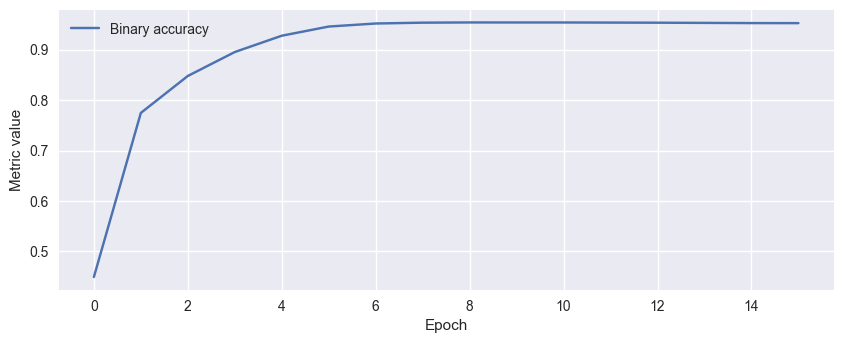

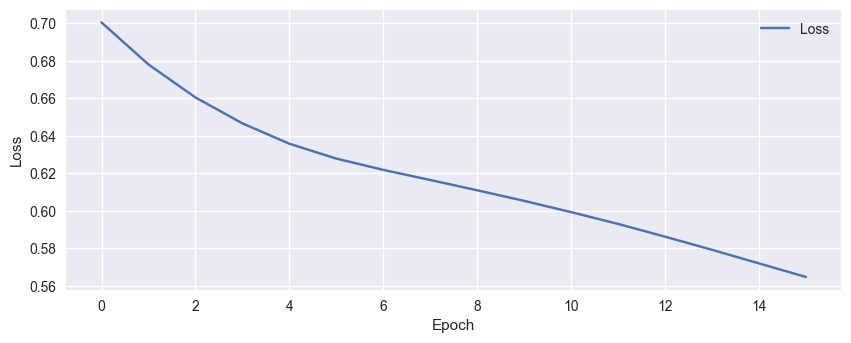

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(training_history.history["binary_accuracy"],label="Binary accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Metric value")
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(2,1,2)
plt.plot(training_history.history["loss"],label="Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
results = model.evaluate(Xtest,Ytest)

143/143 [==============================] - 2s 15ms/step - loss: 0.5591 - binary_accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517


In [19]:
model.save("CAD_detection_model_20ppl.h5")